# **Importing Libraries**

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import Sequential
from sklearn.model_selection import train_test_split

Code Starts


In [4]:
def load_image(image_name,folder_path):
  image_path = os.path.join(folder_path,image_name)
  if os.path.exists(image_path):
    image = Image.open(image_path)
    # plt.imshow(image)
    image = image.resize((128, 128))
    return np.array(image)
  else:
    return None

In [5]:
def generator_with_tensor_conversion(generator):
  for images,labels in generator:
    labels = tuple(tf.convert_to_tensor(label) for label in labels)
    yield images, labels

In [6]:
def plot_Loss(trainingHistory):
  plt.plot(trainingHistory.history['loss'], color='red', label='train')
  plt.plot(trainingHistory.history['val_loss'], color='blue', label='validation')
  plt.legend()
  plt.title('model loss')
  plt.ylabel('loss')

In [7]:
def plot_Individual_Output_Loss(trainingHistory, nums):
  temp = int(nums**(1/2))
  plt.figure(figsize=(10,10))
  for i in range(temp):
    for j in range(temp):
      plt.subplot(temp,temp,i*temp+j+1)
      plt.plot(trainingHistory.history[f'output_{i+j+1}_loss'], color='red', label='train')
      plt.plot(trainingHistory.history[f'val_output_{i+j+1}_loss'], color='blue', label='validation')
      plt.title(f'output_{i+j+1}_loss')

In [8]:
def plot_Individual_Output_Accuracy(trainingHistory, nums):
  temp = int(nums**(1/2))
  plt.figure(figsize=(10,10))
  for i in range(temp):
    for j in range(temp):
      plt.subplot(temp,temp,i*temp+j+1)
      plt.plot(trainingHistory.history[f'output_{i+j+1}_accuracy'], color='red', label='train')
      plt.plot(trainingHistory.history[f'val_output_{i+j+1}_accuracy'], color='blue', label='validation')
      plt.title(f'output_{i+j+1}_accuracy')

In [9]:
def locationPrediction(model,image,num_outputs):
    pred = [model.predict(image.reshape(1,128,128,3))[i].argmax(axis=1) for i in range(num_outputs)]
    return np.array(pred).flatten()

In [10]:
def evaluation_Score(actual_labels,predicted_labels):
  dim = len(actual_labels)**(1/2)
  score = 0
  for i in range(len(actual_labels)):
    x = int(actual_labels[i]/dim)
    x_hat = int(predicted_labels[i]/dim)
    y = int(actual_labels[i]%dim)
    y_hat = int(predicted_labels[i]%dim)
    # print(x,x_hat,y,y_hat)
    score += ((x-x_hat)**2+(y-y_hat)**2)

  print(score/len(actual_labels))
  return score/len(actual_labels)

In [11]:
def dataset_Prediction(model,df,testSize,img_path):
  metric_score = 0
  for i in range(testSize):
    data = df.iloc[i,:]
    values = [data[key] for key in data.keys()]
    img = values[0]
    labels = values[1:]

    labels_predicted = locationPrediction(
        model,
        load_image(img,img_path),
        len(labels)
    )
    print(img,labels,labels_predicted)
    metric_score += evaluation_Score(labels,labels_predicted)

  return metric_score/testSize

In [12]:
def testing_Model(model, csv_File_Name, img_File_Directory, output_File_Name):
  df = pd.read_csv(csv_File_Name)

  for col in df.keys()[1:]:
    df[col] = df[col].map(lambda x: int(x[1])*3+int(x[4]))

  predicted_data = []
  testSize = len(df)
  metric_score = 0

  for i in range(testSize):
    data = df.iloc[i,:]
    values = [data[key] for key in data.keys()]
    img = values[0]
    labels = values[1:]

    labels_predicted = locationPrediction(
        model,
        load_image(img,img_File_Directory),
        len(labels)
    )

    new_labels = []
    dim = len(labels)**(1/2);
    for i in labels_predicted:
      temp = "("
      temp += str(int(i/dim))
      temp += ", "
      temp += str(int(i%dim))
      temp += ")";
      new_labels.append(temp)
    predicted_data.append([img] + new_labels)

    metric_score += evaluation_Score(labels,labels_predicted)
    # print(img,labels,labels_predicted)

  predicted_df = pd.DataFrame(predicted_data, columns=["img_name"]+[column+"_predicted" for column in df.keys()[1:]])
  predicted_df.to_csv(output_File_Name, index=False)
  print(predicted_df)
  return metric_score/testSize

In [17]:
animal_csv_path = 'animal_3_3_jigsaw.csv'
animal_img_path = 'animal_3_3_jigsaw'
human_csv_path = 'human_5_5_jigsaw.csv'
human_img_path = 'human_5_5_jigsaw'

<h1>TRAINING ON ANIMAL DATASET</h1>

In [18]:
df1 = pd.read_csv(animal_csv_path)
df1.head(3)

load_image(df1['image_name'][0],animal_img_path).shape

(128, 128, 3)

In [19]:
for col in df1.keys()[1:]:
  df1[col] = df1[col].map(lambda x: int(x[1])*3+int(x[4]))
df1.head(3)

,image_name,piece_0_0,piece_0_1,piece_0_2,piece_1_0,piece_1_1,piece_1_2,piece_2_0,piece_2_1,piece_2_2
0,0.jpg,1,0,7,5,3,8,2,4,6
1,1.jpg,7,6,5,2,0,8,4,1,3
2,2.jpg,1,0,2,5,8,6,3,7,4


In [20]:
#Normalize
dataset = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [21]:
targetColumns1 = list(df1.keys()[1:])
num_outputs1 = len(targetColumns1)
num_classes1 = num_outputs1
targetColumns1

['piece_0_0',
 'piece_0_1',
 'piece_0_2',
 'piece_1_0',
 'piece_1_1',
 'piece_1_2',
 'piece_2_0',
 'piece_2_1',
 'piece_2_2']

In [22]:
#animal image generators
train_dataset1 = generator_with_tensor_conversion(
    dataset.flow_from_dataframe(
      dataframe = df1,
      directory = animal_img_path,
      x_col = "image_name",
      y_col = targetColumns1,
      subset = "training",
      target_size = (128,128),
      batch_size = 64,
      class_mode = "multi_output",
      shuffle = True
  )
)

validation_dataset1 = generator_with_tensor_conversion(
    dataset.flow_from_dataframe(
      dataframe = df1,
      directory = animal_img_path,
      x_col = "image_name",
      y_col = targetColumns1,
      subset = "validation",
      target_size = (128,128),
      batch_size = 64,
      class_mode = "multi_output",
      shuffle = False
  )
)

Found 6400 validated image filenames.
Found 1600 validated image filenames.


In [23]:
image1, label1 = next(train_dataset1)
print(image1.shape)
print(label1)

(64, 128, 128, 3)
(<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([6, 0, 0, 2, 6, 5, 1, 5, 0, 7, 3, 0, 5, 6, 6, 0, 7, 2, 5, 0, 2, 8,
       5, 2, 5, 7, 2, 5, 4, 4, 1, 1, 2, 4, 0, 1, 5, 5, 1, 6, 1, 1, 5, 3,
       7, 8, 7, 3, 7, 2, 5, 4, 5, 7, 2, 2, 6, 5, 7, 8, 3, 3, 6, 7])>, <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([8, 1, 1, 0, 3, 3, 3, 1, 7, 3, 4, 5, 2, 2, 8, 6, 0, 3, 1, 3, 8, 5,
       1, 8, 8, 5, 5, 0, 7, 1, 2, 3, 7, 3, 6, 5, 7, 7, 7, 1, 3, 2, 2, 5,
       5, 3, 0, 2, 2, 6, 4, 6, 4, 0, 8, 0, 0, 4, 5, 6, 7, 0, 7, 5])>, <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([2, 3, 2, 7, 5, 7, 2, 7, 8, 4, 8, 7, 6, 0, 7, 4, 5, 1, 6, 6, 7, 4,
       8, 6, 2, 8, 6, 7, 0, 3, 0, 0, 5, 0, 1, 6, 4, 4, 2, 4, 8, 4, 3, 1,
       3, 4, 6, 8, 1, 3, 2, 2, 6, 8, 4, 1, 5, 2, 8, 1, 6, 5, 2, 4])>, <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([1, 5, 8, 4, 0, 6, 4, 2, 5, 2, 7, 4, 8, 8, 4, 7, 4, 8, 0, 4, 0, 7,
       7, 7, 1, 3, 0, 4, 8, 0, 3, 8, 1, 5, 8, 8, 3, 6, 4, 8, 7, 8, 6, 6,
       

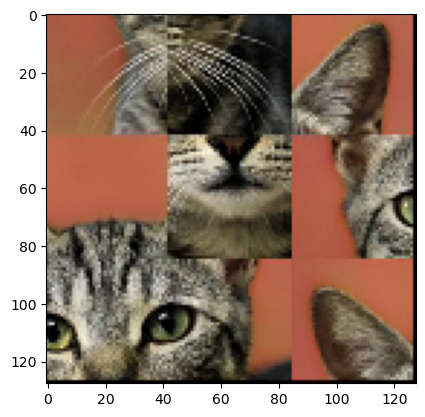

In [24]:
plt.imshow(image1[0])

In [25]:
input_shape1 = (128,128,3)
inputs1 = Input(shape=input_shape1)

x = Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu')(inputs1)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)

outputs1=[]
for i in range(num_outputs1):
  outputs1.append(Dense(num_classes1, activation='softmax', name=f'output_{i+1}')(x))

model1 = Model(inputs=inputs1, outputs=outputs1)

model1.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]'] 

In [30]:
model1.compile(
    optimizer='adam',
    loss=['sparse_categorical_crossentropy'] * num_outputs1,
    metrics=[['accuracy'] for _ in range(num_outputs1)] 
)

In [31]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta = 0.00001,
    patience = 2,
    verbose = 1,
    mode = 'auto',
    baseline=None,
    restore_best_weights=False,
)

In [32]:
history1 = model1.fit(
    train_dataset1,
    validation_data=validation_dataset1,
    epochs=10,
    steps_per_epoch=100,
    validation_steps=25,
    callbacks = callback
  )

Epoch 1/10
100/100 [==============================] - 204s 2s/step - loss: 19.6791 - output_1_loss: 2.1918 - output_2_loss: 2.1855 - output_3_loss: 2.1891 - output_4_loss: 2.1862 - output_5_loss: 2.1830 - output_6_loss: 2.1859 - output_7_loss: 2.1894 - output_8_loss: 2.1791 - output_9_loss: 2.1890 - output_1_accuracy: 0.1308 - output_2_accuracy: 0.1348 - output_3_accuracy: 0.1334 - output_4_accuracy: 0.1384 - output_5_accuracy: 0.1409 - output_6_accuracy: 0.1375 - output_7_accuracy: 0.1317 - output_8_accuracy: 0.1342 - output_9_accuracy: 0.1408 - val_loss: 18.8221 - val_output_1_loss: 2.1155 - val_output_2_loss: 2.0730 - val_output_3_loss: 2.0804 - val_output_4_loss: 2.0926 - val_output_5_loss: 2.0655 - val_output_6_loss: 2.1226 - val_output_7_loss: 2.0760 - val_output_8_loss: 2.0985 - val_output_9_loss: 2.0981 - val_output_1_accuracy: 0.1981 - val_output_2_accuracy: 0.2506 - val_output_3_accuracy: 0.2369 - val_output_4_accuracy: 0.2069 - val_output_5_accuracy: 0.2369 - val_output_6_ac

MODEL PREDICTION AND SCORE CALCULATION

In [33]:
final_score_animal = dataset_Prediction(
    model1,
    df1,
    100,
    animal_img_path
)

print("Final Score of Model on Animal Dataset is",final_score_animal)

1/1 [==============================] - 0s 41ms/step
0.jpg [1, 0, 7, 5, 3, 8, 2, 4, 6] [1 0 7 5 1 8 0 4 8]
1.1111111111111112
1/1 [==============================] - 0s 36ms/step
1.jpg [7, 6, 5, 2, 0, 8, 4, 1, 3] [7 6 5 2 6 8 4 2 3]
0.5555555555555556
1/1 [==============================] - 0s 40ms/step
2.jpg [1, 0, 2, 5, 8, 6, 3, 7, 4] [1 0 2 7 8 4 6 2 4]
1.1111111111111112
1/1 [==============================] - 0s 38ms/step
3.jpg [8, 2, 3, 0, 1, 4, 6, 5, 7] [8 2 3 0 1 4 6 7 7]
0.2222222222222222
1/1 [==============================] - 0s 38ms/step
4.jpg [2, 6, 5, 1, 0, 3, 4, 7, 8] [2 6 5 1 0 3 4 7 6]
0.4444444444444444
1/1 [==============================] - 0s 41ms/step
5.jpg [1, 4, 0, 2, 5, 6, 3, 7, 8] [1 4 0 2 5 6 3 7 8]
0.0
1/1 [==============================] - 0s 41ms/step
6.jpg [5, 4, 2, 6, 1, 8, 0, 7, 3] [5 4 8 0 1 8 6 7 8]
1.8888888888888888
1/1 [==============================] - 0s 42ms/step
7.jpg [8, 1, 7, 6, 5, 4, 3, 2, 0] [6 1 7 2 8 4 4 2 0]
1.5555555555555556
1/1 [==========

1/1 [==============================] - 0s 39ms/step
15.jpg [3, 0, 7, 5, 8, 4, 1, 6, 2] [6 0 7 7 8 4 1 1 2]
0.8888888888888888
1/1 [==============================] - 0s 37ms/step
16.jpg [8, 0, 5, 7, 2, 1, 6, 4, 3] [6 0 5 7 2 1 3 4 3]
0.5555555555555556
1/1 [==============================] - 0s 39ms/step
17.jpg [4, 8, 2, 7, 6, 5, 3, 1, 0] [4 2 0 7 8 5 4 1 0]
1.4444444444444444
1/1 [==============================] - 0s 38ms/step
18.jpg [8, 5, 1, 6, 0, 7, 4, 3, 2] [6 5 5 6 0 8 8 1 0]
1.6666666666666667
1/1 [==============================] - 0s 38ms/step
19.jpg [2, 1, 5, 4, 3, 8, 7, 0, 6] [6 0 5 4 3 2 7 6 1]
2.4444444444444446
1/1 [==============================] - 0s 45ms/step
20.jpg [5, 0, 2, 6, 3, 8, 4, 1, 7] [1 3 2 5 6 8 1 1 7]
1.1111111111111112
1/1 [==============================] - 0s 39ms/step
21.jpg [7, 3, 8, 2, 4, 6, 5, 0, 1] [4 2 8 1 6 0 5 2 1]
1.8888888888888888
1/1 [==============================] - 0s 36ms/step
22.jpg [1, 7, 0, 5, 8, 3, 6, 2, 4] [1 7 0 5 8 5 6 2 4]
0.444444444

1/1 [==============================] - 0s 42ms/step
30.jpg [5, 7, 0, 8, 4, 2, 1, 3, 6] [5 7 0 5 4 2 1 3 0]
0.5555555555555556
1/1 [==============================] - 0s 38ms/step
31.jpg [7, 5, 2, 0, 1, 6, 4, 3, 8] [0 5 2 0 1 6 4 3 8]
0.5555555555555556
1/1 [==============================] - 0s 38ms/step
32.jpg [0, 6, 2, 1, 7, 4, 3, 8, 5] [6 5 2 1 7 4 3 6 6]
2.0
1/1 [==============================] - 0s 38ms/step
33.jpg [2, 1, 5, 8, 0, 6, 3, 4, 7] [2 1 5 8 0 8 3 4 7]
0.4444444444444444
1/1 [==============================] - 0s 40ms/step
34.jpg [1, 3, 4, 8, 6, 7, 5, 2, 0] [1 4 4 1 6 8 5 2 0]
0.7777777777777778
1/1 [==============================] - 0s 41ms/step
35.jpg [6, 5, 8, 3, 0, 2, 1, 4, 7] [6 5 8 3 0 2 0 4 7]
0.1111111111111111
1/1 [==============================] - 0s 37ms/step
36.jpg [3, 2, 0, 7, 5, 6, 4, 1, 8] [3 2 0 7 5 6 6 1 6]
0.6666666666666666
1/1 [==============================] - 0s 38ms/step
37.jpg [5, 4, 3, 2, 6, 0, 8, 1, 7] [5 4 7 2 8 0 1 1 4]
1.3333333333333333
1/1 [==

1/1 [==============================] - 0s 38ms/step
45.jpg [6, 1, 5, 2, 8, 4, 3, 0, 7] [6 6 8 2 8 4 8 3 7]
1.3333333333333333
1/1 [==============================] - 0s 38ms/step
46.jpg [7, 5, 6, 1, 4, 2, 3, 8, 0] [7 5 6 1 4 2 3 2 0]
0.4444444444444444
1/1 [==============================] - 0s 37ms/step
47.jpg [1, 2, 4, 5, 0, 3, 6, 7, 8] [1 2 4 6 1 3 6 7 8]
0.6666666666666666
1/1 [==============================] - 0s 39ms/step
48.jpg [5, 6, 3, 0, 8, 4, 1, 2, 7] [5 6 3 0 4 4 1 2 7]
0.2222222222222222
1/1 [==============================] - 0s 39ms/step
49.jpg [0, 8, 4, 5, 2, 1, 7, 3, 6] [0 8 4 5 2 1 7 3 6]
0.0
1/1 [==============================] - 0s 38ms/step
50.jpg [8, 7, 6, 4, 2, 0, 5, 3, 1] [8 7 6 5 2 0 8 3 1]
0.2222222222222222
1/1 [==============================] - 0s 37ms/step
51.jpg [7, 1, 5, 4, 6, 0, 2, 3, 8] [7 1 5 4 6 0 2 3 4]
0.2222222222222222
1/1 [==============================] - 0s 44ms/step
52.jpg [7, 2, 4, 6, 3, 5, 1, 0, 8] [7 2 5 6 3 5 1 6 8]
0.5555555555555556
1/1 [==

1/1 [==============================] - 0s 35ms/step
60.jpg [6, 8, 3, 7, 1, 5, 0, 4, 2] [6 8 6 3 1 5 0 6 1]
0.6666666666666666
1/1 [==============================] - 0s 36ms/step
61.jpg [8, 5, 7, 1, 4, 0, 6, 3, 2] [1 4 7 7 4 6 6 2 2]
2.111111111111111
1/1 [==============================] - 0s 37ms/step
62.jpg [2, 6, 8, 5, 7, 4, 0, 3, 1] [2 8 8 3 6 8 1 2 1]
1.8888888888888888
1/1 [==============================] - 0s 45ms/step
63.jpg [2, 4, 7, 3, 0, 5, 8, 6, 1] [0 4 7 1 0 5 8 6 1]
0.6666666666666666
1/1 [==============================] - 0s 38ms/step
64.jpg [7, 3, 0, 6, 1, 2, 4, 8, 5] [7 6 0 6 1 2 4 8 8]
0.2222222222222222
1/1 [==============================] - 0s 39ms/step
65.jpg [7, 8, 2, 3, 6, 1, 0, 4, 5] [7 8 2 2 4 1 0 4 5]
0.7777777777777778
1/1 [==============================] - 0s 37ms/step
66.jpg [8, 4, 3, 7, 6, 1, 0, 5, 2] [8 4 3 7 6 3 0 5 6]
1.1111111111111112
1/1 [==============================] - 0s 36ms/step
67.jpg [2, 5, 0, 1, 7, 8, 4, 6, 3] [2 2 0 1 7 8 4 4 1]
0.5555555555

1/1 [==============================] - 0s 38ms/step
75.jpg [0, 6, 3, 8, 5, 1, 2, 4, 7] [0 6 7 2 5 1 7 4 7]
1.2222222222222223
1/1 [==============================] - 0s 41ms/step
76.jpg [1, 7, 5, 0, 2, 3, 8, 6, 4] [3 7 7 0 2 0 6 6 7]
1.1111111111111112
1/1 [==============================] - 0s 43ms/step
77.jpg [2, 7, 5, 6, 8, 4, 1, 3, 0] [2 7 4 6 5 4 1 3 0]
0.2222222222222222
1/1 [==============================] - 0s 36ms/step
78.jpg [5, 3, 7, 8, 4, 6, 0, 1, 2] [5 4 7 6 4 8 0 2 7]
1.6666666666666667
1/1 [==============================] - 0s 38ms/step
79.jpg [5, 1, 8, 4, 3, 6, 7, 0, 2] [5 1 1 4 3 4 8 1 2]
1.0
1/1 [==============================] - 0s 37ms/step
80.jpg [1, 8, 7, 6, 0, 2, 3, 4, 5] [1 8 6 3 0 0 3 4 5]
0.6666666666666666
1/1 [==============================] - 0s 37ms/step
81.jpg [8, 2, 6, 0, 5, 7, 1, 3, 4] [6 2 6 4 5 7 1 8 7]
1.3333333333333333
1/1 [==============================] - 0s 37ms/step
82.jpg [1, 8, 5, 6, 0, 7, 4, 2, 3] [1 6 5 2 0 7 0 2 3]
1.5555555555555556
1/1 [==

1/1 [==============================] - 0s 43ms/step
90.jpg [2, 4, 6, 7, 8, 3, 5, 0, 1] [2 4 7 7 8 3 4 0 0]
0.3333333333333333
1/1 [==============================] - 0s 38ms/step
91.jpg [3, 1, 5, 0, 6, 4, 2, 7, 8] [3 4 5 3 2 4 8 7 0]
2.4444444444444446
1/1 [==============================] - 0s 37ms/step
92.jpg [8, 4, 1, 7, 5, 6, 0, 2, 3] [8 4 7 7 5 3 1 2 0]
0.7777777777777778
1/1 [==============================] - 0s 37ms/step
93.jpg [8, 3, 1, 5, 4, 2, 7, 6, 0] [0 8 1 5 4 2 7 6 6]
1.8888888888888888
1/1 [==============================] - 0s 42ms/step
94.jpg [3, 4, 6, 0, 5, 8, 7, 1, 2] [8 4 6 0 5 8 5 1 2]
0.7777777777777778
1/1 [==============================] - 0s 38ms/step
95.jpg [1, 3, 4, 5, 2, 0, 6, 8, 7] [1 3 4 5 2 0 6 3 7]
0.5555555555555556
1/1 [==============================] - 0s 39ms/step
96.jpg [1, 2, 5, 4, 7, 3, 8, 6, 0] [1 2 5 4 7 8 6 6 0]
1.0
1/1 [==============================] - 0s 38ms/step
97.jpg [5, 0, 4, 6, 7, 1, 2, 8, 3] [5 0 4 6 7 1 6 8 3]
0.8888888888888888
1/1 [==

MODEL EVALUATION

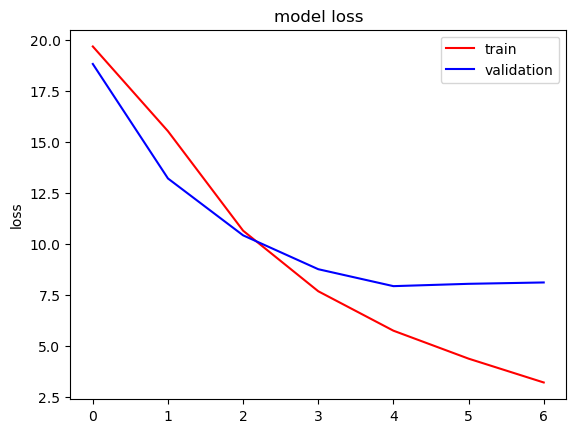

In [37]:
plot_Loss(history1)

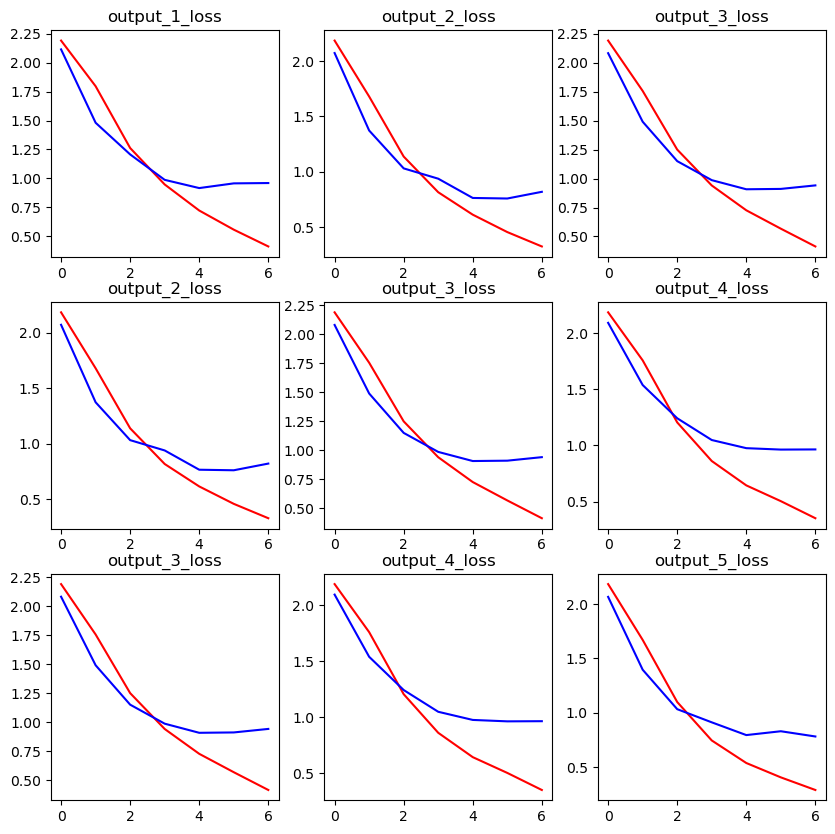

In [38]:
plot_Individual_Output_Loss(history1,num_outputs1)

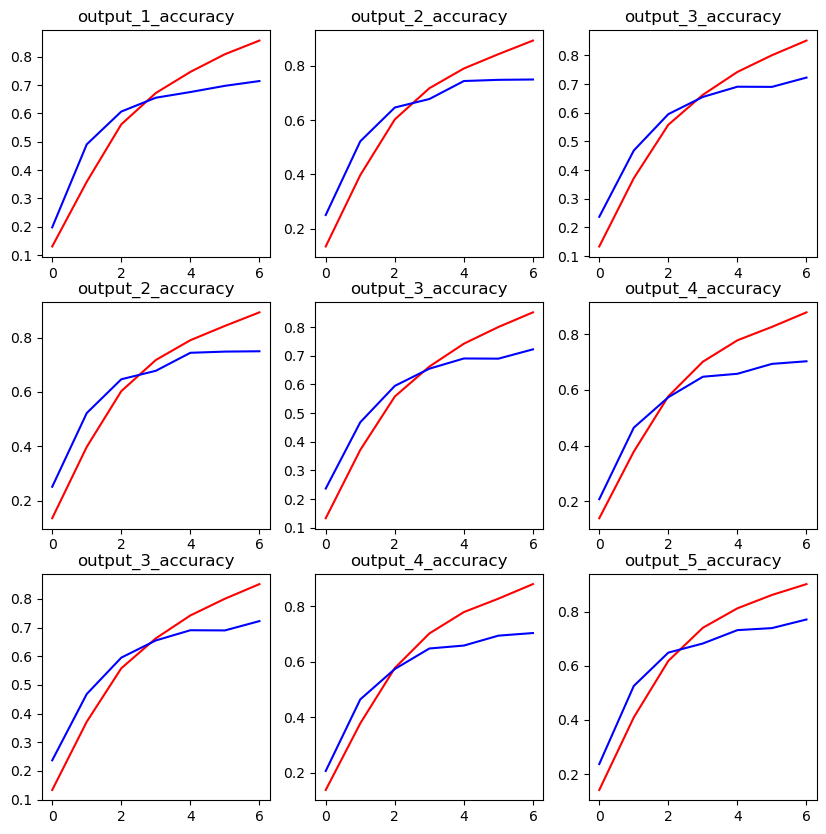

In [39]:
plot_Individual_Output_Accuracy(history1,num_outputs1)

<h1> TRAINING ON HUMAN DATASET </h1>

In [40]:
df2 = pd.read_csv(human_csv_path)
df2.head(3)

,image_name,piece_0_0,piece_0_1,piece_0_2,piece_0_3,piece_0_4,piece_1_0,piece_1_1,piece_1_2,piece_1_3,...,piece_3_0,piece_3_1,piece_3_2,piece_3_3,piece_3_4,piece_4_0,piece_4_1,piece_4_2,piece_4_3,piece_4_4
0,0.jpg,"(0, 3)","(0, 2)","(1, 1)","(3, 0)","(2, 1)","(3, 3)","(4, 1)","(2, 3)","(1, 4)",...,"(4, 3)","(0, 1)","(3, 2)","(0, 0)","(4, 4)","(0, 4)","(2, 0)","(1, 3)","(3, 4)","(2, 4)"
1,1.jpg,"(3, 4)","(0, 1)","(0, 3)","(2, 1)","(4, 1)","(1, 0)","(0, 0)","(3, 1)","(4, 3)",...,"(0, 4)","(4, 2)","(2, 4)","(1, 3)","(3, 2)","(4, 4)","(3, 0)","(0, 2)","(2, 3)","(1, 4)"
2,2.jpg,"(4, 4)","(0, 2)","(1, 2)","(0, 4)","(4, 0)","(0, 3)","(3, 1)","(3, 3)","(1, 1)",...,"(3, 4)","(1, 3)","(3, 2)","(0, 1)","(1, 4)","(2, 3)","(4, 3)","(2, 0)","(4, 2)","(3, 0)"


In [41]:
load_image(df2['image_name'][0],human_img_path).shape

(128, 128, 3)

In [42]:
for col in df2.keys()[1:]:
  df2[col] = df2[col].map(lambda y: int(y[1])*5+int(y[4]))
df2.head(3)

,image_name,piece_0_0,piece_0_1,piece_0_2,piece_0_3,piece_0_4,piece_1_0,piece_1_1,piece_1_2,piece_1_3,...,piece_3_0,piece_3_1,piece_3_2,piece_3_3,piece_3_4,piece_4_0,piece_4_1,piece_4_2,piece_4_3,piece_4_4
0,0.jpg,3,2,6,15,11,18,21,13,9,...,23,1,17,0,24,4,10,8,19,14
1,1.jpg,19,1,3,11,21,5,0,16,23,...,4,22,14,8,17,24,15,2,13,9
2,2.jpg,24,2,7,4,20,3,16,18,6,...,19,8,17,1,9,13,23,10,22,15


In [43]:
#Normalize
dataset = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [44]:
targetColumns2 = list(df2.keys()[1:])
num_outputs2 = len(targetColumns2)
num_classes2 = num_outputs2
targetColumns2

['piece_0_0',
 'piece_0_1',
 'piece_0_2',
 'piece_0_3',
 'piece_0_4',
 'piece_1_0',
 'piece_1_1',
 'piece_1_2',
 'piece_1_3',
 'piece_1_4',
 'piece_2_0',
 'piece_2_1',
 'piece_2_2',
 'piece_2_3',
 'piece_2_4',
 'piece_3_0',
 'piece_3_1',
 'piece_3_2',
 'piece_3_3',
 'piece_3_4',
 'piece_4_0',
 'piece_4_1',
 'piece_4_2',
 'piece_4_3',
 'piece_4_4']

In [45]:
#human image generators
train_dataset2 = generator_with_tensor_conversion(
    dataset.flow_from_dataframe(
      dataframe = df2,
      directory = human_img_path,
      x_col = "image_name",
      y_col = targetColumns2,
      subset = "training",
      target_size = (128,128),
      batch_size = 64,
      class_mode = "multi_output",
      shuffle = True
  )
)

validation_dataset2 = generator_with_tensor_conversion(
    dataset.flow_from_dataframe(
      dataframe = df2,
      directory = human_img_path,
      x_col = "image_name",
      y_col = targetColumns2,
      subset = "validation",
      target_size = (128,128),
      batch_size = 64,
      class_mode = "multi_output",
      shuffle = False
  )
)

Found 6400 validated image filenames.
Found 1600 validated image filenames.


In [46]:
image2, label2 = next(train_dataset2)
image2.shape,label2

((64, 128, 128, 3),
 (<tf.Tensor: shape=(64,), dtype=int32, numpy=
  array([10,  1, 10, 20,  2,  2, 15, 19,  8, 21, 24,  0,  4, 15,  2, 18, 11,
         16, 15, 22, 13, 10, 12, 11, 24,  1, 16, 10,  9, 15, 19,  6, 12,  5,
         13,  1, 20,  1, 14, 24, 16, 12,  8, 17, 17, 11, 15,  0, 18,  0, 21,
         11,  4,  1, 18, 21, 15, 10, 23, 24,  9,  9, 14, 24])>,
  <tf.Tensor: shape=(64,), dtype=int32, numpy=
  array([17,  8, 15,  7, 11, 18, 16, 24, 18, 22,  9, 17, 20, 22, 10,  8,  1,
          6, 17, 21,  3, 11,  0,  1,  0,  5,  5,  1, 22,  5, 18, 21, 15,  1,
         21, 16,  2, 20, 10, 10,  1, 11,  3, 24, 19,  2, 12,  9, 12,  6, 18,
         23, 14,  6,  8, 11, 12, 24, 21,  6, 16, 11,  6,  0])>,
  <tf.Tensor: shape=(64,), dtype=int32, numpy=
  array([22, 14, 11,  1, 21, 12,  9,  2,  4,  2,  0, 13, 12,  8,  1,  2, 13,
          2, 23,  0, 24, 15, 13,  2, 23, 21, 17,  8, 21,  6, 24, 23, 11, 17,
          0, 15, 23, 24, 11, 14, 17, 10, 21, 11, 21, 23,  9, 10, 21, 14, 23,
         19,  6, 1

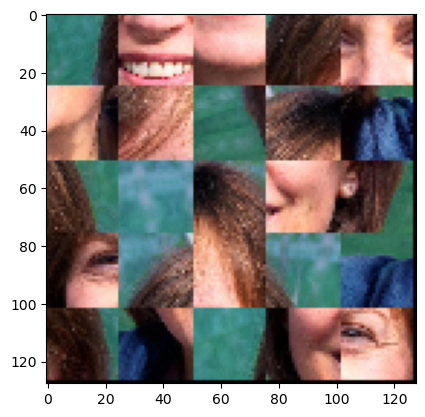

In [47]:
plt.imshow(image2[0])

In [48]:
input_shape2 = (128,128,3)
inputs2 = Input(shape=input_shape2)

x = Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu')(inputs2)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)

outputs2=[]
for i in range(num_outputs2):
  outputs2.append(Dense(num_classes2, activation='softmax', name=f'output_{i+1}')(x))

model2 = Model(inputs=inputs2, outputs=outputs2)

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 126, 126, 32)         896       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)           0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d_3[0][0]'

In [50]:
model2.compile(
    optimizer='adam',
    loss = ['sparse_categorical_crossentropy']*num_outputs2,
    metrics=[['accuracy'] for _ in range(num_outputs2)]
)

In [51]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta = 0.00001,
    patience = 2,
    verbose = 1,
    mode = 'auto',
    baseline=None,
    restore_best_weights=False,
)

In [52]:
history2 = model2.fit(
    train_dataset2,
    validation_data=validation_dataset2,
    epochs=30,
    steps_per_epoch=100,
    validation_steps=25,
    callbacks = callback
  )

Epoch 1/30
100/100 [==============================] - 347s 3s/step - loss: 80.4989 - output_1_loss: 3.2193 - output_2_loss: 3.2201 - output_3_loss: 3.2197 - output_4_loss: 3.2198 - output_5_loss: 3.2201 - output_6_loss: 3.2193 - output_7_loss: 3.2195 - output_8_loss: 3.2201 - output_9_loss: 3.2193 - output_10_loss: 3.2187 - output_11_loss: 3.2198 - output_12_loss: 3.2206 - output_13_loss: 3.2207 - output_14_loss: 3.2198 - output_15_loss: 3.2201 - output_16_loss: 3.2207 - output_17_loss: 3.2198 - output_18_loss: 3.2201 - output_19_loss: 3.2194 - output_20_loss: 3.2197 - output_21_loss: 3.2202 - output_22_loss: 3.2208 - output_23_loss: 3.2203 - output_24_loss: 3.2204 - output_25_loss: 3.2206 - output_1_accuracy: 0.0389 - output_2_accuracy: 0.0405 - output_3_accuracy: 0.0386 - output_4_accuracy: 0.0406 - output_5_accuracy: 0.0427 - output_6_accuracy: 0.0413 - output_7_accuracy: 0.0445 - output_8_accuracy: 0.0366 - output_9_accuracy: 0.0408 - output_10_accuracy: 0.0383 - output_11_accuracy

Epoch 4/30
100/100 [==============================] - 156s 2s/step - loss: 75.0795 - output_1_loss: 3.0978 - output_2_loss: 2.9350 - output_3_loss: 3.0539 - output_4_loss: 3.0409 - output_5_loss: 3.1143 - output_6_loss: 3.0387 - output_7_loss: 2.9445 - output_8_loss: 2.9418 - output_9_loss: 2.9331 - output_10_loss: 3.0387 - output_11_loss: 2.9770 - output_12_loss: 2.9209 - output_13_loss: 2.9094 - output_14_loss: 2.9023 - output_15_loss: 3.0520 - output_16_loss: 3.0052 - output_17_loss: 2.9129 - output_18_loss: 2.9431 - output_19_loss: 2.9282 - output_20_loss: 3.0123 - output_21_loss: 3.1041 - output_22_loss: 3.0274 - output_23_loss: 3.0559 - output_24_loss: 3.0719 - output_25_loss: 3.1180 - output_1_accuracy: 0.1017 - output_2_accuracy: 0.1359 - output_3_accuracy: 0.1044 - output_4_accuracy: 0.1100 - output_5_accuracy: 0.1000 - output_6_accuracy: 0.1112 - output_7_accuracy: 0.1511 - output_8_accuracy: 0.1408 - output_9_accuracy: 0.1408 - output_10_accuracy: 0.1061 - output_11_accuracy

Epoch 7/30
100/100 [==============================] - 135s 1s/step - loss: 64.9739 - output_1_loss: 2.7451 - output_2_loss: 2.4979 - output_3_loss: 2.6701 - output_4_loss: 2.6332 - output_5_loss: 2.8255 - output_6_loss: 2.6540 - output_7_loss: 2.4887 - output_8_loss: 2.4752 - output_9_loss: 2.4932 - output_10_loss: 2.6806 - output_11_loss: 2.5825 - output_12_loss: 2.4841 - output_13_loss: 2.4930 - output_14_loss: 2.4498 - output_15_loss: 2.6900 - output_16_loss: 2.6172 - output_17_loss: 2.4498 - output_18_loss: 2.4775 - output_19_loss: 2.4566 - output_20_loss: 2.5922 - output_21_loss: 2.7678 - output_22_loss: 2.5989 - output_23_loss: 2.6252 - output_24_loss: 2.6958 - output_25_loss: 2.8301 - output_1_accuracy: 0.1886 - output_2_accuracy: 0.2522 - output_3_accuracy: 0.2091 - output_4_accuracy: 0.2255 - output_5_accuracy: 0.1752 - output_6_accuracy: 0.2183 - output_7_accuracy: 0.2562 - output_8_accuracy: 0.2670 - output_9_accuracy: 0.2614 - output_10_accuracy: 0.2116 - output_11_accuracy

Epoch 10/30
100/100 [==============================] - 139s 1s/step - loss: 59.0574 - output_1_loss: 2.5158 - output_2_loss: 2.2751 - output_3_loss: 2.4303 - output_4_loss: 2.4105 - output_5_loss: 2.5947 - output_6_loss: 2.4114 - output_7_loss: 2.2576 - output_8_loss: 2.2520 - output_9_loss: 2.2487 - output_10_loss: 2.4574 - output_11_loss: 2.3533 - output_12_loss: 2.2299 - output_13_loss: 2.2674 - output_14_loss: 2.2250 - output_15_loss: 2.4687 - output_16_loss: 2.3701 - output_17_loss: 2.1938 - output_18_loss: 2.2316 - output_19_loss: 2.1908 - output_20_loss: 2.3407 - output_21_loss: 2.5421 - output_22_loss: 2.3544 - output_23_loss: 2.3773 - output_24_loss: 2.4480 - output_25_loss: 2.6108 - output_1_accuracy: 0.2420 - output_2_accuracy: 0.3077 - output_3_accuracy: 0.2681 - output_4_accuracy: 0.2783 - output_5_accuracy: 0.2239 - output_6_accuracy: 0.2700 - output_7_accuracy: 0.3170 - output_8_accuracy: 0.3192 - output_9_accuracy: 0.3180 - output_10_accuracy: 0.2619 - output_11_accurac

Epoch 12: early stopping


MODEL PREDICTION AND SCORE CALCULATION

In [53]:
final_score_human = dataset_Prediction(
    model2,
    df2,
    100,
    human_img_path
)
print("Final Score of Model on Human Dataset is",final_score_human)

1/1 [==============================] - 0s 41ms/step
0.jpg [3, 2, 6, 15, 11, 18, 21, 13, 9, 12, 7, 20, 16, 22, 5, 23, 1, 17, 0, 24, 4, 10, 8, 19, 14] [ 1  2  7  0  6  0 11 13  2 16 18  3 22 22 23  3 20 17 22  5 17  0 23  2
  5]
9.12
1/1 [==============================] - 0s 38ms/step
1.jpg [19, 1, 3, 11, 21, 5, 0, 16, 23, 12, 7, 6, 20, 10, 18, 4, 22, 14, 8, 17, 24, 15, 2, 13, 9] [ 8 20 23 12 16 15  3 16 23  6  8 23  1 24 20 14 22  3  6 22 14  4  0 13
  6]
6.88
1/1 [==============================] - 0s 38ms/step
2.jpg [24, 2, 7, 4, 20, 3, 16, 18, 6, 14, 11, 12, 0, 5, 21, 19, 8, 17, 1, 9, 13, 23, 10, 22, 15] [ 2 12  8  1 15  2  6 22 11 22 11 18 13 24  2 10  8 17  9 15 13 21  5  7
 22]
6.96
1/1 [==============================] - 0s 39ms/step
3.jpg [10, 1, 4, 19, 13, 17, 8, 12, 14, 11, 6, 7, 18, 20, 2, 23, 5, 0, 16, 24, 22, 21, 15, 3, 9] [ 3  6 17  4 13  2  8 11  3 16  2  3 18 23 11  3  7 24 16 20 16  9  8 18
  1]
7.6
1/1 [==============================] - 0s 36ms/step
4.jpg [5, 13, 24, 16,

1/1 [==============================] - 0s 40ms/step
5.jpg [13, 23, 12, 1, 0, 4, 20, 17, 3, 16, 15, 18, 6, 21, 22, 9, 5, 24, 19, 7, 10, 8, 2, 14, 11] [16 22 16  0  6 17 18 11  3 16  3 12 10 15 10 22 21 19 24 18 22  8 13 21
  2]
5.16
1/1 [==============================] - 0s 38ms/step
6.jpg [20, 15, 22, 24, 17, 11, 23, 9, 16, 12, 19, 0, 14, 7, 6, 18, 21, 3, 4, 1, 2, 8, 10, 13, 5] [16  9 16 17 17 11 12 14 20 21 13 14 21 17 11 22  6 14  8 11  1 23  0 13
 24]
5.72
1/1 [==============================] - 0s 43ms/step
7.jpg [2, 10, 9, 15, 4, 3, 11, 22, 19, 6, 24, 7, 20, 0, 1, 13, 21, 18, 8, 16, 23, 14, 17, 5, 12] [21  7 18  1  5  3 11 22 19 16 15  2 11  4  0 13 21 23 13 16 23  3 11 13
 12]
4.68
1/1 [==============================] - 0s 38ms/step
8.jpg [2, 0, 23, 10, 5, 14, 17, 18, 9, 11, 3, 16, 13, 19, 7, 20, 21, 1, 12, 4, 24, 22, 8, 6, 15] [17 21 18 16 14  2 13 18 23 11  9 16  7 11  7 20 21  1 13 20 13 21  8 23
  4]
6.28
1/1 [==============================] - 0s 41ms/step
9.jpg [4, 16, 6, 15,

1/1 [==============================] - 0s 40ms/step
11.jpg [23, 5, 7, 20, 19, 6, 10, 18, 8, 9, 4, 0, 16, 14, 1, 11, 24, 3, 15, 12, 13, 21, 22, 2, 17] [20 21  7 15 22 12  2  8  8 14  5 21 18 19  1 11  3  9 15  6 13  6 18  5
 12]
4.68
1/1 [==============================] - 0s 38ms/step
12.jpg [19, 18, 2, 12, 1, 22, 21, 16, 11, 5, 8, 10, 6, 24, 23, 14, 3, 0, 15, 9, 4, 13, 7, 20, 17] [21 18 18 24  1 16 19  6 11  1 19  0 21 24 10  2 24  5  7 15  8 13 13  8
 12]
6.16
1/1 [==============================] - 0s 40ms/step
13.jpg [6, 12, 5, 14, 11, 7, 23, 21, 16, 13, 10, 19, 17, 2, 9, 1, 22, 4, 15, 8, 0, 20, 18, 3, 24] [13 13 21 16 11  7  0  9  3 17  0  5  8  2 20  0 16  3 17  8  6 14 18 18
  9]
7.44
1/1 [==============================] - 0s 49ms/step
14.jpg [14, 24, 16, 6, 3, 9, 18, 13, 2, 17, 7, 22, 8, 0, 19, 1, 20, 12, 23, 15, 11, 4, 21, 5, 10] [13 14  8  6 19 20 11 13  2 16 18 19  8  9 15 21  6 17  9 24 16 10  8  4
  5]
8.12
1/1 [==============================] - 0s 44ms/step
15.jpg [0, 6, 18

1/1 [==============================] - 0s 41ms/step
16.jpg [19, 21, 15, 22, 11, 14, 13, 3, 5, 0, 20, 24, 9, 4, 1, 12, 10, 18, 7, 2, 8, 23, 17, 16, 6] [ 0  6  9 17 11 24 13 17  3  2 10  1  3 13  9 16 20 18  6  1 22 17 16 16
 19]
6.52
1/1 [==============================] - 0s 38ms/step
17.jpg [11, 21, 1, 0, 24, 16, 9, 13, 2, 5, 3, 12, 19, 17, 8, 4, 7, 6, 14, 10, 15, 22, 23, 20, 18] [11 16  5 13 10 16  3 17  9 10  3  7 19 17  7 14 23  6  5  8  8 18 18  2
 23]
5.04
1/1 [==============================] - 0s 43ms/step
18.jpg [24, 13, 14, 6, 1, 15, 9, 3, 16, 21, 5, 19, 7, 8, 22, 12, 17, 0, 2, 23, 18, 11, 20, 4, 10] [17 13 16  6 14  8 24 20 16 16 20 15  8 24  7 23 17  3  2 21  5 18  8  8
  4]
7.88
1/1 [==============================] - 0s 39ms/step
19.jpg [13, 7, 22, 16, 17, 15, 24, 3, 23, 20, 5, 10, 2, 14, 19, 18, 21, 8, 4, 1, 0, 11, 9, 12, 6] [ 1  8 18 11 13  1  4 23 22 19 20  3  1 23 11 18 21 11 23  6 14 11 12 12
  6]
6.4
1/1 [==============================] - 0s 41ms/step
20.jpg [11, 15, 1

1/1 [==============================] - 0s 37ms/step
22.jpg [6, 1, 9, 10, 0, 8, 16, 23, 20, 5, 17, 4, 7, 12, 21, 15, 3, 13, 19, 2, 14, 11, 22, 18, 24] [ 7 21  1 10 15 23 16 21  1  5 20  1  8 13  6  6  3 13  3 13 14  7 22  3
 19]
4.92
1/1 [==============================] - 0s 37ms/step
23.jpg [19, 17, 15, 21, 10, 22, 3, 0, 18, 16, 7, 1, 20, 13, 12, 24, 5, 14, 9, 2, 8, 23, 11, 6, 4] [ 5 13 20 24  2  6 20 15  6 24 22  6 23 13 16  9 10 21 11 21  8 18 22 16
 24]
7.96
1/1 [==============================] - 0s 40ms/step
24.jpg [1, 5, 3, 2, 6, 13, 16, 22, 0, 19, 20, 14, 15, 10, 11, 23, 4, 21, 24, 8, 12, 9, 17, 7, 18] [ 0 16  2  9 21 13 16  1 22  7 10 13  0  0 13 19  3  6 23  3 18 24  6 14
 13]
4.96
1/1 [==============================] - 0s 38ms/step
25.jpg [5, 11, 15, 10, 24, 2, 8, 18, 13, 7, 6, 3, 17, 20, 19, 22, 23, 9, 16, 4, 21, 0, 1, 14, 12] [ 0 11 13  9 19  2  3 22 13 22  6 16 17  0  0  7 11 20 11 20 18  4 11  6
 12]
8.2
1/1 [==============================] - 0s 38ms/step
26.jpg [18, 23, 2

1/1 [==============================] - 0s 42ms/step
27.jpg [6, 5, 4, 12, 18, 3, 17, 2, 22, 20, 9, 23, 10, 7, 1, 21, 13, 8, 16, 19, 14, 24, 15, 11, 0] [17  0 14  6 18 24 17  8 18  2  1  8 21  7 11 21 11  8  7 23 19  1  3 11
  0]
5.44
1/1 [==============================] - 0s 38ms/step
28.jpg [15, 4, 7, 21, 2, 10, 6, 5, 11, 1, 20, 18, 13, 3, 22, 24, 12, 9, 0, 14, 17, 8, 16, 23, 19] [15  3 18 16 16 24  6 24  6 20 10 13  2 15 24  4 13  0  3  4  7  4  8  8
 16]
7.64
1/1 [==============================] - 0s 38ms/step
29.jpg [17, 0, 19, 6, 16, 20, 13, 2, 7, 14, 22, 23, 18, 15, 5, 24, 4, 10, 8, 12, 1, 11, 9, 21, 3] [22 20 22  9  6  2 13  2 22  6  2 14 18 15 20 23  5 11  5  7 19 24  9 21
  1]
6.72
1/1 [==============================] - 0s 40ms/step
30.jpg [0, 6, 15, 22, 14, 8, 12, 11, 9, 7, 1, 3, 23, 10, 19, 20, 2, 21, 5, 13, 18, 24, 17, 16, 4] [ 0  6  5  8  6 13 16 11  3 17  2  5  8 20  9 19  1 22 20 13 18 15 17 18
  1]
4.76
1/1 [==============================] - 0s 40ms/step
31.jpg [4, 19, 2

1/1 [==============================] - 0s 38ms/step
33.jpg [0, 11, 8, 20, 18, 7, 24, 9, 21, 19, 10, 17, 23, 5, 12, 1, 13, 4, 6, 2, 3, 16, 22, 14, 15] [ 9 11 13  3 16 11 14 24  6 15  3 17  7  0 12  4 13 24  5  2 20  9  5  6
 22]
8.12
1/1 [==============================] - 0s 40ms/step
34.jpg [18, 8, 1, 10, 2, 5, 6, 16, 20, 9, 13, 21, 14, 7, 19, 11, 4, 12, 23, 22, 0, 15, 17, 24, 3] [23  8 24 15 17 23 16 21 22  1 13  5 10 11  4 11 20 12 12 13  6  8 17  5
 13]
7.84
1/1 [==============================] - 0s 41ms/step
35.jpg [3, 9, 11, 17, 19, 24, 7, 18, 13, 1, 22, 14, 21, 8, 15, 2, 10, 6, 12, 20, 0, 4, 16, 23, 5] [ 1 15 17 16 22  3 10  8  7 11 22  9 12 13 21 11  0 16 12  1  1  0  8 21
  4]
5.96
1/1 [==============================] - 0s 40ms/step
36.jpg [9, 23, 24, 19, 2, 17, 14, 8, 13, 4, 21, 0, 11, 10, 18, 22, 6, 15, 16, 1, 12, 3, 20, 7, 5] [16 14  7  9 16 17 18 23 13 11  2 15 13 24 18 22 11  3 16  6 16 10 14 14
 15]
7.32
1/1 [==============================] - 0s 39ms/step
37.jpg [9, 23, 3

1/1 [==============================] - 0s 36ms/step
38.jpg [6, 16, 23, 24, 22, 2, 9, 15, 20, 7, 1, 11, 8, 5, 19, 13, 17, 18, 4, 12, 3, 0, 10, 21, 14] [ 6  6 10 11 12  2 22 22  3  3  2 11  8 15  9 13  7 16 20 23  6 21 15  3
 22]
7.36
1/1 [==============================] - 0s 39ms/step
39.jpg [23, 9, 11, 13, 4, 16, 14, 5, 12, 18, 3, 0, 24, 19, 22, 15, 17, 6, 1, 7, 10, 8, 2, 20, 21] [24 19  3 12 22 13  3  0 10 17 21  5  4 20 22 20 22 16  2 22  9  4 23  5
 11]
6.76
1/1 [==============================] - 0s 42ms/step
40.jpg [16, 14, 8, 3, 20, 12, 24, 17, 9, 15, 23, 2, 19, 1, 5, 22, 10, 11, 18, 7, 4, 6, 0, 13, 21] [ 6 14  6 17  3 17  8  7 16  1 23  5 10 14 21 11 10 17 22 11  0 23  5  8
 15]
6.8
1/1 [==============================] - 0s 37ms/step
41.jpg [13, 9, 18, 21, 0, 3, 6, 23, 2, 10, 11, 22, 20, 19, 4, 14, 12, 24, 1, 16, 17, 8, 5, 7, 15] [17 14 18  7 19 15  8  5  6 21 11 22  4  6 24 10 11  0 10  6  7 17  4 16
  4]
10.4
1/1 [==============================] - 0s 41ms/step
42.jpg [20, 21, 2

1/1 [==============================] - 0s 42ms/step
44.jpg [11, 5, 24, 19, 14, 3, 1, 23, 18, 12, 20, 17, 22, 16, 8, 4, 0, 9, 21, 13, 10, 2, 15, 6, 7] [11 10 12  0  6 19 18  7 22 11 10 17 16 16 18  3 14  4 16  8  0  6  1 21
 18]
5.76
1/1 [==============================] - 0s 39ms/step
45.jpg [7, 22, 6, 18, 1, 21, 19, 15, 11, 4, 0, 14, 10, 5, 9, 17, 24, 13, 8, 12, 23, 20, 16, 2, 3] [19 18  6  3 16 21  6  5 11  9 23  2  3 21  6 17 20 13 22 11 14 10  4 11
  3]
6.8
1/1 [==============================] - 0s 37ms/step
46.jpg [18, 6, 15, 20, 2, 22, 16, 4, 19, 3, 9, 11, 12, 7, 8, 21, 24, 13, 1, 14, 0, 23, 5, 10, 17] [18  5 24 10  0 17 16 18 24  6  0 11 18  7 11  2  9 13  3  8  3  6 14  2
 17]
5.84
1/1 [==============================] - 0s 38ms/step
47.jpg [8, 11, 15, 13, 19, 24, 7, 5, 17, 16, 12, 10, 9, 23, 2, 0, 14, 20, 1, 4, 6, 3, 21, 18, 22] [13 20 15 14  3 20 11  2 18 16 16  6  2 24  1 13  6  0 21 20  6 21  8 18
 12]
7.04
1/1 [==============================] - 0s 38ms/step
48.jpg [14, 23, 2

1/1 [==============================] - 0s 37ms/step
49.jpg [2, 19, 14, 12, 21, 5, 17, 0, 8, 24, 11, 18, 23, 15, 20, 7, 3, 1, 16, 10, 13, 22, 4, 6, 9] [22 14 20  6 16  2 23  8  8  8 17 16  9  0  0 10  2 10 16  5 13 22  3  6
  1]
5.24
1/1 [==============================] - 0s 40ms/step
50.jpg [4, 12, 24, 13, 18, 3, 20, 7, 6, 22, 8, 5, 15, 9, 21, 1, 19, 16, 17, 23, 0, 14, 10, 2, 11] [ 5 11 20 12 12 23 10 12  9 22 11  5 15 19 16 14 24 16 12 17  6 14  0  3
 13]
4.2
1/1 [==============================] - 0s 39ms/step
51.jpg [8, 16, 17, 7, 9, 13, 15, 5, 6, 22, 2, 19, 21, 0, 14, 24, 1, 10, 20, 18, 11, 4, 12, 23, 3] [12 11 16  0  6 11  5 24  9 17  0  5  6 17  7  5 22  6 14  8 22  4 18 18
  3]
7.52
1/1 [==============================] - 0s 40ms/step
52.jpg [22, 18, 15, 23, 14, 20, 0, 17, 6, 9, 16, 24, 13, 8, 5, 7, 21, 10, 11, 12, 4, 1, 2, 19, 3] [22 16 24  7 14 12  1  9 13 15 11  3 18  8  1  8 21 21 11 18 19  4  2 24
 13]
5.0
1/1 [==============================] - 0s 41ms/step
53.jpg [1, 15, 12,

1/1 [==============================] - 0s 38ms/step
55.jpg [23, 4, 5, 1, 24, 0, 18, 3, 14, 21, 13, 20, 11, 6, 8, 9, 12, 22, 15, 10, 7, 19, 16, 17, 2] [13 17  5  9 15 20 18  9 24 13 12 16 21 16 13 22 11  8  9  9 18 20  6 17
  3]
6.96
1/1 [==============================] - 0s 39ms/step
56.jpg [5, 21, 4, 18, 24, 20, 9, 16, 1, 12, 14, 17, 13, 15, 6, 8, 0, 10, 19, 2, 11, 7, 3, 22, 23] [20 16  1  8  3  8  4  7  2  7  9  7 12  0  3  1 10  6  2 24 11  7 23 18
 23]
5.92
1/1 [==============================] - 0s 38ms/step
57.jpg [17, 14, 3, 15, 24, 22, 19, 20, 9, 2, 4, 10, 7, 0, 6, 16, 12, 11, 13, 1, 8, 21, 23, 5, 18] [ 6  9  0 16 22  7  1 23 19  6  5  5 17 12  5 16 18 11 13 23  2 21  8  6
 18]
5.08
1/1 [==============================] - 0s 38ms/step
58.jpg [19, 24, 16, 23, 6, 13, 3, 4, 0, 21, 5, 14, 12, 8, 18, 2, 7, 10, 22, 15, 11, 9, 20, 17, 1] [15 20 16 14  6 13  3  0 13 11 21  6 16 24 10 24  8 19 11  3 18  1 13  7
  0]
8.24
1/1 [==============================] - 0s 39ms/step
59.jpg [20, 23, 

1/1 [==============================] - 0s 39ms/step
60.jpg [10, 11, 21, 7, 18, 0, 9, 13, 2, 17, 14, 19, 24, 3, 23, 6, 1, 12, 16, 15, 22, 20, 5, 8, 4] [24 22 12 18  6 11 17 12  1 22 21  5 21  9 23 15  1  1  2  8 23 19  5  8
 24]
6.8
1/1 [==============================] - 0s 42ms/step
61.jpg [14, 7, 16, 0, 8, 11, 18, 5, 12, 3, 22, 4, 1, 15, 6, 24, 2, 20, 19, 9, 17, 13, 21, 10, 23] [24  8 22  2  8 11 13  6 13 23  7 10  7  1 12 19  2 18 22  0 10 11  9  6
  4]
6.08
1/1 [==============================] - 0s 41ms/step
62.jpg [4, 20, 21, 10, 18, 6, 0, 2, 24, 23, 22, 7, 16, 17, 8, 13, 1, 15, 12, 3, 14, 9, 11, 19, 5] [24 22 16 24 18  6 20  1 14 23 21 13  2  7  0 13 20 19  7  3  9  5 13 20
 18]
6.96
1/1 [==============================] - 0s 38ms/step
63.jpg [19, 3, 8, 17, 7, 12, 20, 24, 15, 13, 11, 23, 6, 4, 14, 18, 2, 10, 5, 1, 16, 9, 22, 21, 0] [18  3  8 12 11  8  4  6  3 13 11 19  2  9 18 18 11 10 20  9 16 10  8 22
  9]
6.0
1/1 [==============================] - 0s 38ms/step
64.jpg [19, 0, 22,

1/1 [==============================] - 0s 38ms/step
66.jpg [2, 13, 6, 3, 20, 18, 19, 1, 23, 12, 22, 4, 11, 10, 14, 17, 8, 16, 7, 24, 15, 0, 9, 5, 21] [11 13  6  3  4 22 14 20 19  2 22 17 12  2  5 17  8 12 16 23  5  2  9 15
 18]
5.08
1/1 [==============================] - 0s 42ms/step
67.jpg [1, 16, 8, 6, 2, 19, 3, 4, 13, 22, 5, 7, 10, 18, 17, 21, 15, 23, 9, 20, 24, 0, 14, 11, 12] [18  7  6 18 12 17 22  8 13 16 22  7 10 13 13 11  3  2  4 10 21  6 24 11
 24]
5.68
1/1 [==============================] - 0s 36ms/step
68.jpg [2, 9, 15, 7, 24, 5, 11, 23, 13, 20, 12, 4, 17, 21, 6, 14, 22, 18, 0, 10, 3, 8, 1, 19, 16] [11 14 18  2 19  0 13  8 13 22  7 16 17 16  8 21 22 17 10  0 14 19  1  6
 23]
4.36
1/1 [==============================] - 0s 41ms/step
69.jpg [21, 10, 7, 22, 3, 11, 24, 6, 12, 15, 23, 18, 4, 5, 17, 8, 9, 0, 14, 13, 2, 20, 19, 16, 1] [ 0 24  8 18  6 11 22  2 17 19 12 12 24 19  2 23  1  9 21 13 16 19  0 21
  0]
8.92
1/1 [==============================] - 0s 38ms/step
70.jpg [14, 17, 

1/1 [==============================] - 0s 49ms/step
71.jpg [5, 9, 7, 17, 14, 21, 10, 12, 18, 2, 3, 11, 19, 0, 4, 20, 13, 8, 22, 1, 16, 23, 15, 24, 6] [19  2 14  9 16 21 24 16 11  2 23 12  1 16 23  0 13  8  7 19 16  8  4  6
  9]
9.64
1/1 [==============================] - 0s 55ms/step
72.jpg [12, 20, 6, 14, 13, 0, 16, 3, 19, 15, 22, 21, 2, 11, 4, 23, 10, 18, 8, 1, 9, 5, 7, 24, 17] [17 17  6 20 17  5 12  9 14 22 11  2  3 11  4  7 15 18  7  4  3  5 22 18
 13]
3.92
1/1 [==============================] - 0s 40ms/step
73.jpg [12, 18, 3, 13, 15, 8, 10, 5, 14, 7, 23, 17, 19, 24, 20, 4, 16, 6, 21, 9, 11, 0, 22, 2, 1] [11 12  8 12  9  6 10  0  2  3  4  8  6 20 19  1 16  6 14 23 11 11 18 16
  7]
6.36
1/1 [==============================] - 0s 36ms/step
74.jpg [12, 18, 1, 15, 0, 4, 3, 13, 14, 2, 20, 23, 10, 19, 7, 16, 5, 17, 6, 22, 8, 11, 24, 9, 21] [11 12  2 17  9 13 17 11  0 17  5  3 20 15 14 16 24 18  6  7  4 11 19 14
  6]
6.84
1/1 [==============================] - 0s 45ms/step
75.jpg [15, 14, 

1/1 [==============================] - 0s 42ms/step
77.jpg [9, 12, 19, 18, 10, 0, 8, 17, 3, 16, 22, 24, 13, 20, 23, 6, 7, 14, 4, 15, 2, 11, 21, 1, 5] [ 3 12 14 19  3  2 21 23  2 14 22 19 17 21  8 21 16  5 22  5 16 11 16 16
  9]
6.04
1/1 [==============================] - 0s 37ms/step
78.jpg [24, 16, 22, 12, 6, 23, 13, 1, 0, 17, 4, 14, 7, 21, 15, 3, 9, 20, 2, 5, 8, 19, 10, 11, 18] [15 22 17 12 22 12 17 17  3 18 14  5 13 15 16  5 14  4  2 14 18 17 10 11
  6]
6.36
1/1 [==============================] - 0s 38ms/step
79.jpg [16, 23, 13, 19, 21, 15, 0, 3, 6, 18, 22, 5, 7, 8, 12, 24, 10, 2, 14, 9, 17, 20, 1, 11, 4] [ 9  8 13 16 17  2  6  3  6  0 11  5  7  8 23  0  5 17  8 15  7  4 21 11
  9]
7.72
1/1 [==============================] - 0s 38ms/step
80.jpg [0, 11, 3, 17, 6, 5, 8, 16, 14, 2, 20, 12, 23, 4, 10, 19, 24, 9, 22, 7, 21, 13, 18, 15, 1] [ 1  7  9 22  6 19  8 10  3 14  2 11 18  0  9  3  7 21 16 12 18  6 17  3
  1]
6.76
1/1 [==============================] - 0s 37ms/step
81.jpg [21, 5, 2

1/1 [==============================] - 0s 38ms/step
82.jpg [2, 1, 5, 13, 21, 9, 22, 3, 19, 4, 18, 8, 23, 14, 17, 10, 6, 11, 7, 24, 12, 20, 15, 16, 0] [18 19  9 18  4 17 22  8 23 16 19 18 10  0  3 13 17  7 21 22 11  1 14 11
 24]
9.8
1/1 [==============================] - 0s 38ms/step
83.jpg [22, 2, 12, 5, 20, 14, 11, 15, 8, 7, 4, 9, 1, 3, 13, 6, 23, 21, 16, 18, 10, 19, 0, 24, 17] [17 16 12  2 12  0 17 15 12 22 10 16 20 23 22 10 14 16 16 18  3  0  3 13
 13]
7.6
1/1 [==============================] - 0s 39ms/step
84.jpg [1, 23, 4, 12, 10, 8, 20, 9, 16, 2, 5, 11, 22, 13, 18, 14, 21, 7, 24, 3, 17, 0, 19, 15, 6] [19 11 14 12  0  8 10  0 16  2  2 11 22 23 18 15 11 13 15 23  6  4  8  3
 18]
6.88
1/1 [==============================] - 0s 39ms/step
85.jpg [6, 22, 15, 21, 14, 17, 0, 8, 23, 7, 19, 11, 18, 4, 9, 16, 20, 13, 1, 2, 24, 10, 12, 5, 3] [ 6 21 21  6 19 17  3  7  8 17  0 23  8 14  5  3 19 11 16  8  4 19 14  5
 12]
7.2
1/1 [==============================] - 0s 38ms/step
86.jpg [13, 1, 9, 1

1/1 [==============================] - 0s 40ms/step
88.jpg [15, 18, 1, 22, 7, 11, 10, 0, 24, 19, 4, 8, 16, 17, 5, 13, 9, 20, 21, 3, 14, 12, 2, 6, 23] [ 5 16 21 15  5  6 11  0 14 23 10 13 20 23  4  8 24 24 22 22  9 13  9 12
 13]
5.6
1/1 [==============================] - 0s 38ms/step
89.jpg [12, 10, 18, 20, 4, 9, 8, 22, 11, 14, 7, 13, 3, 1, 5, 6, 2, 21, 16, 23, 0, 24, 17, 19, 15] [20  2  7 17 16  5 23 22 23  8 11 16  3  1 21  7  3 18  7 18  9 12  8 20
 18]
6.6
1/1 [==============================] - 0s 38ms/step
90.jpg [19, 2, 20, 10, 11, 4, 16, 13, 17, 7, 22, 18, 15, 1, 21, 6, 3, 8, 9, 0, 5, 23, 12, 24, 14] [10  7 14 10 13 20  4 12 17  0 22 18  8  0  6 21  2  8  9 15  2  1  6 20
 12]
7.48
1/1 [==============================] - 0s 37ms/step
91.jpg [14, 17, 9, 16, 7, 24, 13, 12, 3, 6, 0, 23, 19, 8, 21, 22, 4, 2, 20, 1, 11, 15, 18, 5, 10] [ 1 12 20  4 16  1 13  7  8 11  9 23 24  8 15 24  6  1 21 21 12 21  8 13
 16]
6.44
1/1 [==============================] - 0s 37ms/step
92.jpg [6, 11, 12,

1/1 [==============================] - 0s 37ms/step
93.jpg [16, 5, 17, 4, 7, 20, 10, 0, 1, 3, 12, 21, 14, 13, 24, 8, 2, 15, 6, 23, 11, 19, 22, 9, 18] [21 10 17  4  8 11  4  0 21 14 11 21  2 13  5 18 12 20  6  2 19  4  8 20
 11]
6.72
1/1 [==============================] - 0s 38ms/step
94.jpg [11, 14, 10, 20, 0, 23, 17, 3, 2, 24, 13, 21, 19, 4, 16, 18, 9, 1, 7, 6, 12, 22, 15, 5, 8] [12 23 15  8  3 10 17 13  2 14 13  6 15 22  0  8  9  1 22  6 12 12 18 19
  4]
6.32
1/1 [==============================] - 0s 41ms/step
95.jpg [2, 16, 5, 23, 1, 18, 21, 8, 3, 9, 19, 20, 22, 17, 13, 11, 7, 24, 15, 6, 4, 12, 14, 10, 0] [17 16  0 13  9  6  2 20 17 20  4  4  7  7 13 11 17 14 15 16 14 11 15 24
 24]
9.68
1/1 [==============================] - 0s 39ms/step
96.jpg [24, 7, 16, 1, 14, 11, 12, 8, 23, 20, 15, 6, 5, 10, 0, 13, 22, 4, 3, 18, 19, 17, 9, 21, 2] [17 11  9  4  7 11 22  2 19 10 14  6 19 24  6 13  6 14 21 20 21  4  8  3
 22]
8.36
1/1 [==============================] - 0s 39ms/step
97.jpg [8, 16, 1

1/1 [==============================] - 0s 39ms/step
99.jpg [16, 6, 17, 18, 5, 10, 21, 4, 11, 23, 24, 0, 1, 14, 3, 9, 20, 8, 7, 19, 12, 15, 2, 13, 22] [21  6 13 22  0 19 12  6 11 12  9  0 21  2  1  0 14  5  7 15  7  3  5  8
 18]
6.76
Final Score of Model on Human Dataset is 6.765200000000001


MODEL EVALUATION

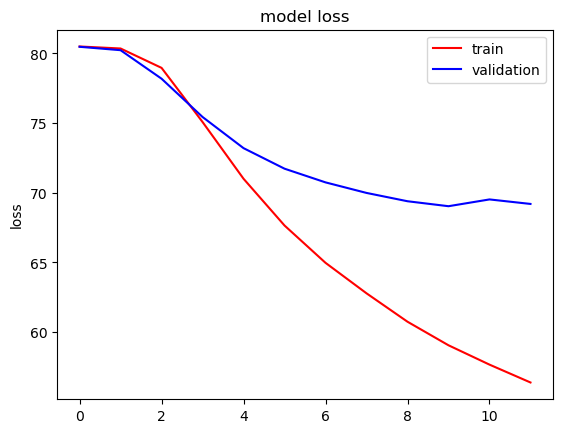

In [54]:
plot_Loss(history2)

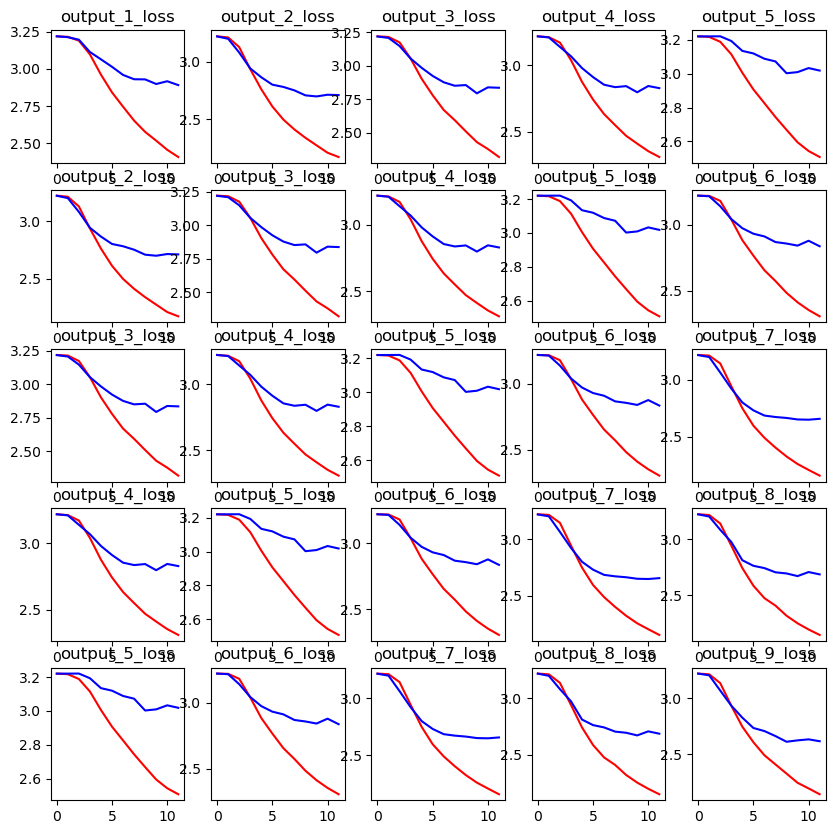

In [55]:
plot_Individual_Output_Loss(history2,num_outputs2)

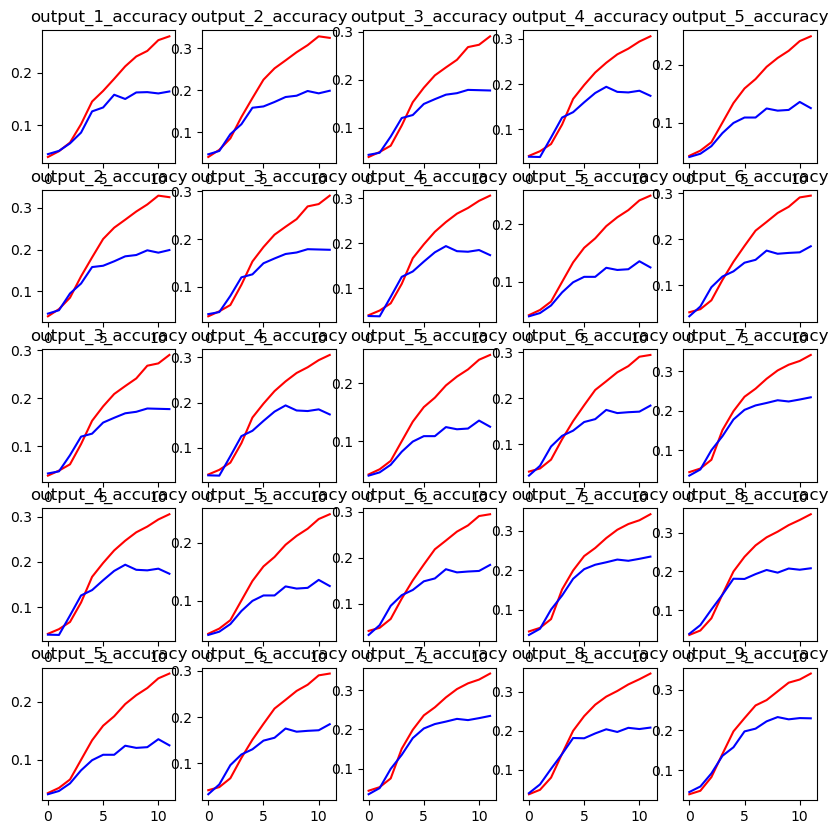

In [56]:
plot_Individual_Output_Accuracy(history2,num_outputs2)


<H1>FINAL SCORE CALCULATION</H1>

In [57]:
print("Score of Model on Animal Dataset : ",final_score_animal)
print("Score of Model on Human Dataset : ",final_score_human)
print("Final Weighted Score : ",0.6*final_score_human + 0.4*final_score_animal)

Score of Model on Animal Dataset :  0.928888888888889
Score of Model on Human Dataset :  6.765200000000001
Final Weighted Score :  4.430675555555556


<H1>TESTING THE MODEL</H1>



*   use model1 for testing of Animal Puzzle
*   List ite



In [ ]:
# testing_Model(model, csv_File_Name, img_File_Directory, output_File_Name)